<a href="https://colab.research.google.com/github/anniegao2013/Hello-world/blob/main/Winter_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [2]:
!pip install transformers

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/CAIS++/Winter Project

Mounted at /content/drive
/content/drive/My Drive/CAIS++/Winter Project


In [4]:
import pandas as pd
import json

data = []
with open("Sarcasm_Headlines_Dataset.json", 'r') as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.sample(10)

Number of training sentences: 26,709



,article_link,headline,is_sarcastic
16070,https://politics.theonion.com/advisors-hopeful...,advisors hopeful jeb bush finally has momentum...,1
13709,https://www.theonion.com/fetish-only-realized-...,fetish only realized after watching wife drown,1
13248,https://politics.theonion.com/congress-orders-...,congress orders clerk to see if he has any in ...,1
7760,https://www.theonion.com/archaeologists-discov...,archaeologists discover world's first guy name...,1
1501,https://www.huffingtonpost.com/entry/snl-angel...,'snl' version of angela merkel is not happy do...,0
25952,https://www.huffingtonpost.com/entry/ian-bremm...,how a political scientist broke the news of tr...,0
11403,https://local.theonion.com/34-year-old-asks-fo...,34-year-old asks for big piece,1
16365,https://www.huffingtonpost.com/entry/kelly-cla...,"kelly clarkson felt 'suppressed,' says top cou...",0
26038,https://politics.theonion.com/trump-we-will-fi...,trump: 'we will fight in afghanistan until vic...,1
13745,https://www.huffingtonpost.com/entry/im-still-...,i'm still here episode 3: an epidemic of epide...,0


In [5]:
headlines = df.headline.values
labels = df.is_sarcastic.values

In [6]:
from transformers import BertTokenizer

print("Loading BERT tokenizer")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
maxLen = 0
for sent in headlines:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    maxLen = max(maxLen, len(input_ids))

print('Max sentence length: ', maxLen)

Max sentence length:  66


In [8]:
input_ids = []
attention_masks = []

for sent in headlines:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 70,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', headlines[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  former versace store clerk sues over secret 'black code' for minority shoppers
Token IDs: tensor([  101,  2280, 18601,  3401,  3573,  7805,  9790,  2015,  2058,  3595,
         1005,  2304,  3642,  1005,  2005,  7162,  4497,  7347,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [9]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} testing samples'.format(test_size))

18,696 training samples
2,670 validation samples
5,343 testing samples


In [10]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [11]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [12]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
from transformers import get_linear_schedule_with_warmup
epochs = 2
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [14]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [17]:
import time
import datetime

def format_time(elapsed):

    elapsed_rounded = int(round((elapsed)))

    return str(datetime.timedelta(seconds=elapsed_rounded))

In [16]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):


    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)


            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)


    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    585.    Elapsed: 0:00:16.
  Batch    80  of    585.    Elapsed: 0:00:32.
  Batch   120  of    585.    Elapsed: 0:00:47.
  Batch   160  of    585.    Elapsed: 0:01:03.
  Batch   200  of    585.    Elapsed: 0:01:20.
  Batch   240  of    585.    Elapsed: 0:01:36.
  Batch   280  of    585.    Elapsed: 0:01:52.
  Batch   320  of    585.    Elapsed: 0:02:08.
  Batch   360  of    585.    Elapsed: 0:02:24.
  Batch   400  of    585.    Elapsed: 0:02:40.
  Batch   440  of    585.    Elapsed: 0:02:56.
  Batch   480  of    585.    Elapsed: 0:03:12.
  Batch   520  of    585.    Elapsed: 0:03:28.
  Batch   560  of    585.    Elapsed: 0:03:44.

  Average training loss: 0.28
  Training epoch took: 0:03:54

Running Validation...
  Accuracy: 0.92
  Validation Loss: 0.21
  Validation took: 0:00:12

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    585.    Elapsed: 0:00:16.
  Batch    80  of    585.    Elapsed: 0:00:32.
  Batch  

In [18]:
import pandas as pd

pd.set_option('display.precision', 2)

df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.28,0.21,0.92,0:03:54,0:00:12
2,0.13,0.23,0.92,0:03:54,0:00:12


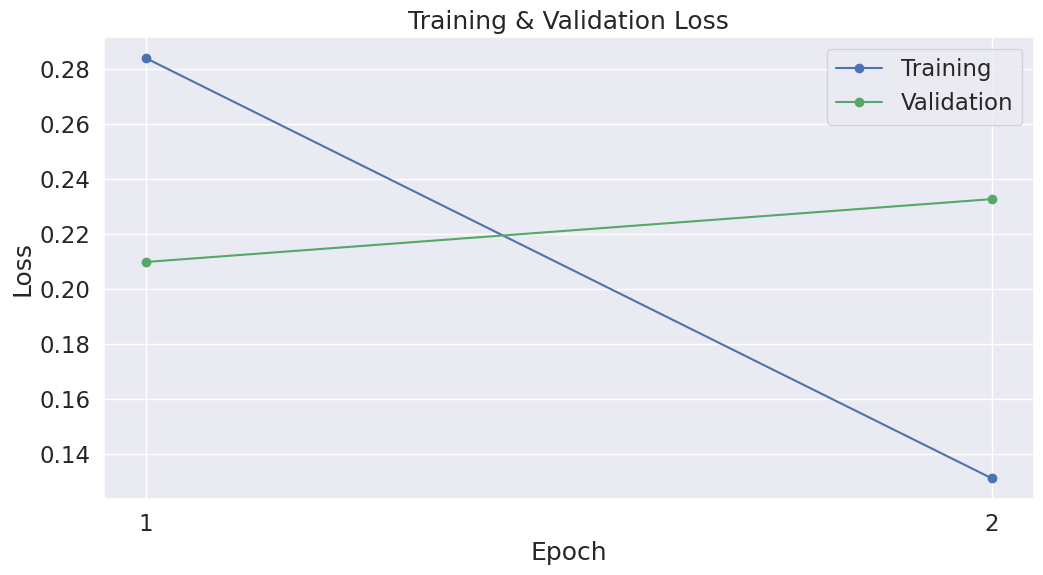

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2])

plt.show()

In [21]:
test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size
        )

In [35]:

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

model.eval()

predictions , true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 26,709 test sentences...
    DONE.


In [30]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

print('Calculating Matthews Corr. Coef. for each batch...')

for i in range(len(true_labels)):

  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


<ipython-input-34-b03fd1c97796>:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)


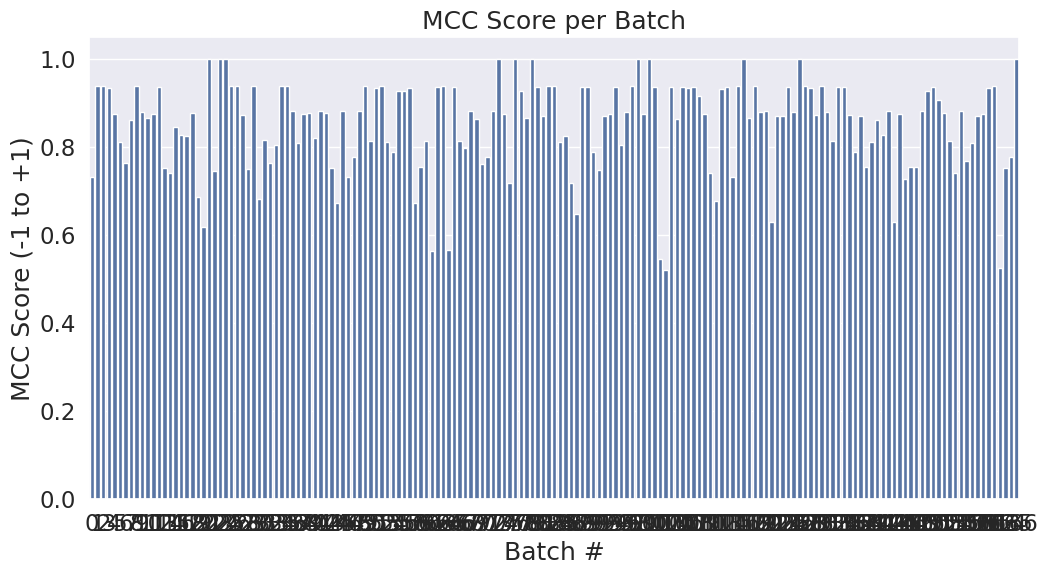

In [34]:
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [32]:
flat_predictions = np.concatenate(predictions, axis=0)

flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

flat_true_labels = np.concatenate(true_labels, axis=0)

mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.851
